In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle
import json
import new_files
import pandas as pd
import nibabel as nb
from os import sep
from copy import deepcopy
from scipy.interpolate import interp1d
from matplotlib import colors
import matplotlib.pylab as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import colors
import trimesh
import open3d as o3d
from tools import compute_rel_power, get_crossover, detect_crossing_points, data_to_rgb
from sklearn.preprocessing import minmax_scale
from joblib import Parallel, delayed

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [15]:
def custom_draw_geometry(mesh, filename="render.png", visible=True, wh=[960, 960], save=True):
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=wh[0], height=wh[1], visible=visible)
    if isinstance(mesh, list):
        for i in mesh:
            vis.add_geometry(i)
    else:
        vis.add_geometry(mesh)
    vis.get_render_option().mesh_show_back_face=True
    vis.get_render_option().light_on=True
    vis.run()
    if save:
        vis.capture_screen_image(filename, do_render=True)
    vis.destroy_window()

In [6]:
dir_search = new_files.Files()
dataset_path = "/home/common/bonaiuto/multiburst/derivatives/processed/"

all_psd_wholebrain = dir_search.get_files(
    dataset_path,
    "*.npy", prefix="PSD_"
)
all_psd_wholebrain.sort()
dict_epoch = {i: [j for j in all_psd_wholebrain if i in j] for i in ["motor", "visual"]}
all_info = dir_search.get_files(
    dataset_path,
    "*.json", prefix="info"
)

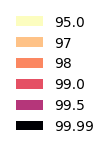

In [22]:
# METRIC VISUALISATION
prc_range = [95., 97, 98, 99.0, 99.5, 99.99]
cm = plt.colormaps["magma_r"]
col_val = np.linspace(0, 0.5,num=len(prc_range)-1)
col_val = np.append(col_val, 1)
label_colours = cm(col_val)[:,:3]

legend_items = []
for ix, lab in enumerate(prc_range):
    p = Patch(
        facecolor=label_colours[ix],
        label="{}".format(lab)
    )
    legend_items.append(p)
f, ax = plt.subplots(figsize=(1,1))
ax.legend(handles=legend_items, loc="center", frameon=False)
ax.axis("off");

In [125]:
dict_epoch["motor"]

['/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/multilayer_11/inverted/PSD_autoreject-sub-001-ses-01-001-motor-epo.npy',
 '/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/multilayer_11/inverted/PSD_autoreject-sub-001-ses-01-002-motor-epo.npy',
 '/home/common/bonaiuto/multiburst/derivatives/processed/sub-002/multilayer_11/inverted/PSD_autoreject-sub-002-ses-03-001-motor-epo.npy',
 '/home/common/bonaiuto/multiburst/derivatives/processed/sub-003/multilayer_11/inverted/PSD_autoreject-sub-003-ses-01-001-motor-epo.npy',
 '/home/common/bonaiuto/multiburst/derivatives/processed/sub-003/multilayer_11/inverted/PSD_autoreject-sub-003-ses-01-002-motor-epo.npy',
 '/home/common/bonaiuto/multiburst/derivatives/processed/sub-004/multilayer_11/inverted/PSD_autoreject-sub-004-ses-01-001-motor-epo.npy',
 '/home/common/bonaiuto/multiburst/derivatives/processed/sub-004/multilayer_11/inverted/PSD_autoreject-sub-004-ses-01-002-motor-epo.npy',
 '/home/common/bonaiuto/multiburst

In [149]:
data_file = dict_epoch["motor"][13]
data = np.load(data_file)
core_path = sep.join(data_file.split(sep)[:-1]) + sep
core_name = data_file.split(sep)[-1].split("_")[-1].split(".")[0]
subject = "-".join(core_name.split("-")[1:3])
info_file = [i for i in all_info if subject in i][0]
with open(info_file) as pipeline_file:
    info = json.load(pipeline_file)

data = np.array(np.split(data, 11, axis=0)) # layer x vertex x freqs
print(core_name)

IndexError: list index out of range

In [148]:

# METRIC VISUALISATION
power_metric = np.sum(np.mean(data, axis=0), axis=-1)

brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
gray = np.array([0.5, 0.5, 0.5])
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)

for ix, pr in enumerate(prc_range):
    map_perc = power_metric >= np.percentile(power_metric, pr)
    colours[map_perc] = label_colours[ix]

mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
shapes = [mesh]
custom_draw_geometry(shapes, save=False)